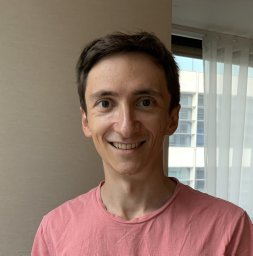
# Sergey Zagoruyko

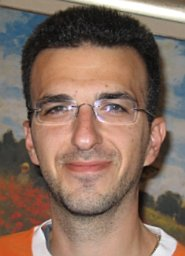
# Nikos Komodakis

## Wide Residual Networks

# https://arxiv.org/pdf/1605.07146

# Abstract

This paper challenges the prevailing assumption that increasing depth is the primary driver of performance in residual networks. It demonstrates that very deep but thin ResNets suffer from diminishing feature reuse and inefficient training. Through a systematic architectural study, the authors propose **Wide Residual Networks (WRNs)**, which reduce depth while substantially increasing width. WRNs achieve superior accuracy, faster training, and state-of-the-art results across CIFAR-10, CIFAR-100, SVHN, COCO, and ImageNet, often outperforming networks with tens or hundreds of times more layers.

---

## Problems

### Diminishing Feature Reuse  
Identity skip connections allow gradients to bypass residual blocks, causing many layers in very deep networks to contribute little to representation learning.

### Inefficient Scaling with Depth  
Accuracy gains in thin ResNets require nearly doubling network depth, leading to slow training and poor computational efficiency.

### Suboptimal Architecture Bias  
Prior research focused heavily on extreme depth and bottleneck blocks, potentially overlooking more effective width-based designs.

### Overfitting with Increased Capacity  
Widening networks increases the number of parameters, raising concerns about overfitting and the need for stronger regularization.

---

## Proposed Solutions

### Width over Depth  
Replace extremely deep, thin ResNets with moderately deep but significantly wider architectures.

### Wide Residual Blocks  
Increase the number of feature channels by a widening factor \( k \) while keeping standard \( 3 \times 3 \) convolutions:
$$
\text{Channels}_{\text{WRN}} = k \times \text{Channels}_{\text{ResNet}}
$$

### Optimal Block Design  
Demonstrate that the basic two-layer residual block
$$
3 \times 3 \;\rightarrow\; 3 \times 3
$$
is more effective than deeper or mixed-kernel alternatives.

### Dropout within Residual Blocks  
Insert dropout between convolutions (after ReLU) to regularize wide networks without degrading optimization.

---

## Purpose

The objective is to identify the architectural factors that truly drive residual network performance and to design models that are more accurate, faster to train, and computationally efficient, while avoiding unnecessary depth.

---

## Methodology

Conduct extensive controlled experiments on CIFAR-10, CIFAR-100, SVHN, ImageNet, and COCO.

Systematically vary:
- Residual block structure (kernel combinations and layers per block)
- Network depth
- Network width (widening factor \( k \))
- Dropout placement and usage

Compare WRNs against thin ResNets (including models exceeding 1000 layers) under matched parameter budgets and training conditions.

Evaluate both predictive performance and computational efficiency, including training time per batch.

---

## Results

### Width Consistently Outperforms Depth  
WRNs with 16–40 layers outperform thin ResNets with more than 1000 layers on CIFAR benchmarks.

### State-of-the-Art Performance
- CIFAR-10: 3.8% error (WRN-40-10)
- CIFAR-100: 18.3% error
- SVHN: 1.54% error
- ImageNet: WRN-50-2-bottleneck surpasses ResNet-152 with fewer layers and faster training
- COCO: WRN-34-2 achieves state-of-the-art single-model object detection performance

### Efficiency Gains  
WRNs train up to 8× faster than thin ResNets with comparable accuracy.

### Dropout Effectiveness  
Properly placed dropout improves generalization, stabilizes training, and complements batch normalization in wide architectures.

---

## Conclusions

The findings show that the core strength of residual networks lies in the residual block design rather than extreme depth. Increasing width is a more effective and efficient strategy for improving performance than stacking hundreds or thousands of layers. Wide Residual Networks deliver better accuracy across multiple benchmarks while significantly reducing training time, redefining best practices for deep convolutional architecture design.


## Key Problems and Research Gaps in Residual Networks

| **Key Problems / Research Gaps Identified** | **How These Limit Prior Work** | **How This Paper Proposes to Solve Them** |
|--------------------------------------------|--------------------------------|-------------------------------------------|
| **Depth-focused scaling yields diminishing returns** | Achieving small accuracy gains often requires nearly doubling network depth, making training, tuning, and iteration increasingly inefficient | Shift the scaling strategy from extreme depth to increased width, introducing **Wide Residual Networks (WRNs)** that trade depth for wider residual blocks |
| **Diminishing feature reuse in very deep ResNets** | Identity shortcuts allow gradients to bypass residual branches, causing many blocks to learn weak or redundant representations and wasting depth and computation | Increase residual branch capacity via widening so each block learns more informative features; demonstrate that fewer, wider blocks can match or exceed very deep thin networks |
| **Limited architectural exploration beyond depth and activation ordering** | Prior analyses focused mainly on pre-activation variants and depth, leaving other architectural dimensions underexplored (block composition, width, dropout placement) | Conduct a systematic empirical study varying block structures, number of convolutions per block, and network width to identify effective residual designs |
| **Unclear optimal residual block structure under fixed parameter budgets** | Alternative block designs (e.g., 1×1 substitutions or deeper blocks) may reduce representational quality or hinder optimization, but prior work lacked controlled comparisons | Experimentally compare multiple block variants and show that the standard two-layer 3×3 block is near-optimal; focus subsequent designs on widened \( B(3,3) \) blocks |
| **Overfitting risk when widening increases parameters** | Increasing width raises model capacity and can lead to overfitting, particularly when batch normalization alone is insufficient | Introduce dropout inside residual blocks (between convolutions) as a targeted regularizer; cross-validate dropout rates and show consistent error reductions on CIFAR and SVHN |
| **Computational inefficiency of very deep thin networks on GPUs** | Sequential depth with narrow layers underutilizes GPU parallelism, leading to long training times and impractical scaling | Use wider layers to improve hardware utilization, substantially reducing training time while improving accuracy |
| **Uncertainty about whether extreme depth provides unique regularization** | Prior claims suggested depth itself may act as a regularizer, but results confound depth with optimization difficulty and parameterization | Provide controlled comparisons showing that wide networks with similar parameter counts match or outperform very deep thin networks, indicating that depth alone is not a reliable source of regularization |


In [1]:
# ============================================================
# Wide Residual Networks Lab
# ============================================================

# -----------------------------
# 1. Imports and setup
# -----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import random
import time

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# -----------------------------
# 2. Hyperparameters
# -----------------------------
BATCH_SIZE = 128
EPOCHS = 10                 # small for teaching & speed
LR = 0.1
WEIGHT_DECAY = 5e-4
WIDTH_FACTOR = 4            # k in WRN
DEPTH = 16                  # WRN-16-k
NUM_CLASSES = 10
DROPOUT_RATE = 0.3

In [3]:
# -----------------------------
# 3. CIFAR-10 dataset
# -----------------------------
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616)),
])

train_dataset = datasets.CIFAR10(root="./data", train=True,
                                 download=True, transform=transform_train)
test_dataset  = datasets.CIFAR10(root="./data", train=False,
                                 download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2)

classes = train_dataset.classes

100%|██████████| 170M/170M [00:05<00:00, 33.9MB/s]


In [4]:
# -----------------------------
# 4. Wide Residual Block
# -----------------------------
class WideBasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1, dropout=0.0):
        super().__init__()

        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)

        self.dropout = nn.Dropout(p=dropout)

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)

        # Shortcut for dimension change
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels,
                                      kernel_size=1, stride=stride,
                                      bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.dropout(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)
        return out

In [5]:
# -----------------------------
# 5. Wide Residual Network
# -----------------------------
class WideResNet(nn.Module):

    def __init__(self, depth, widen_factor, num_classes, dropout):
        super().__init__()

        assert (depth - 4) % 6 == 0, "Depth must follow WRN formula"
        n = (depth - 4) // 6

        channels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]

        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3,
                               stride=1, padding=1, bias=False)

        self.layer1 = self._make_layer(channels[0], channels[1],
                                       n, stride=1, dropout=dropout)
        self.layer2 = self._make_layer(channels[1], channels[2],
                                       n, stride=2, dropout=dropout)
        self.layer3 = self._make_layer(channels[2], channels[3],
                                       n, stride=2, dropout=dropout)

        self.bn = nn.BatchNorm2d(channels[3])
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride, dropout):
        layers = []
        layers.append(WideBasicBlock(in_channels, out_channels, stride, dropout))
        for _ in range(1, num_blocks):
            layers.append(WideBasicBlock(out_channels, out_channels, 1, dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return self.fc(out)

In [6]:
# -----------------------------
# 6. Model, loss, optimizer
# -----------------------------
model = WideResNet(DEPTH, WIDTH_FACTOR, NUM_CLASSES, DROPOUT_RATE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR,
                      momentum=0.9, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                           milestones=[5, 8],
                                           gamma=0.2)

In [7]:
# -----------------------------
# 7. Training & evaluation loops
# -----------------------------
train_losses, test_losses = [], []
train_accs, test_accs = [], []

def evaluate(loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            loss_sum += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return loss_sum / total, correct / total

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    scheduler.step()

    train_loss = running_loss / total
    train_acc = correct / total
    test_loss, test_acc = evaluate(test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}")

Epoch 1/10 | Train Acc: 0.418 | Test Acc: 0.362
Epoch 2/10 | Train Acc: 0.616 | Test Acc: 0.600
Epoch 3/10 | Train Acc: 0.680 | Test Acc: 0.510
Epoch 4/10 | Train Acc: 0.724 | Test Acc: 0.665
Epoch 5/10 | Train Acc: 0.750 | Test Acc: 0.665
Epoch 6/10 | Train Acc: 0.822 | Test Acc: 0.802
Epoch 7/10 | Train Acc: 0.840 | Test Acc: 0.826
Epoch 8/10 | Train Acc: 0.848 | Test Acc: 0.805
Epoch 9/10 | Train Acc: 0.873 | Test Acc: 0.833
Epoch 10/10 | Train Acc: 0.880 | Test Acc: 0.839


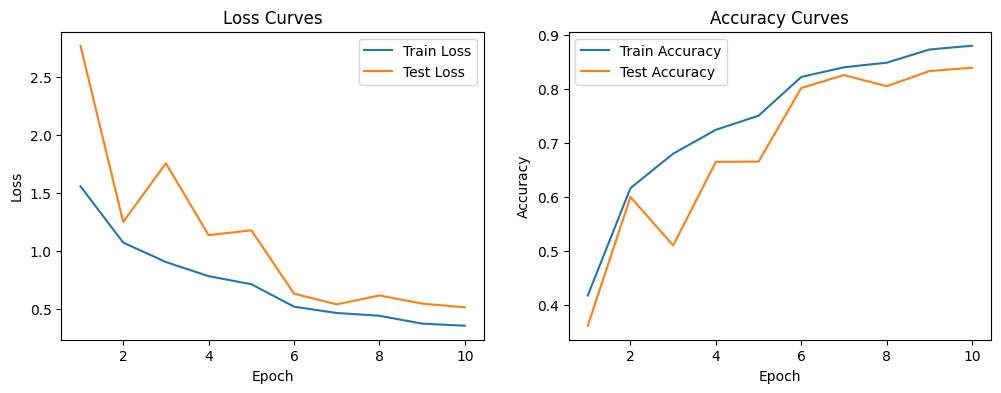

In [8]:
# -----------------------------
# 8. Training curves
# -----------------------------
epochs = range(1, EPOCHS+1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.show()

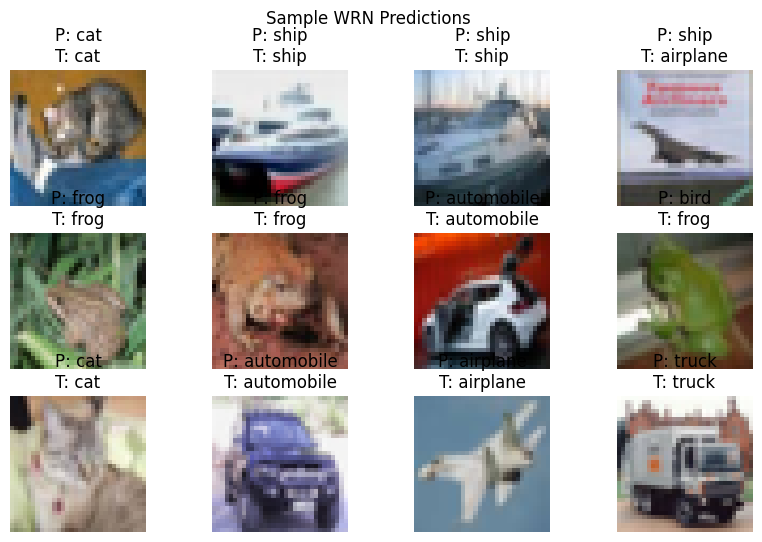

In [9]:
# -----------------------------
# 9. Sample predictions visualization
# -----------------------------
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

images = images.cpu()
labels = labels.cpu()
preds  = preds.cpu()

plt.figure(figsize=(10,6))
for i in range(12):
    plt.subplot(3,4,i+1)
    img = images[i].permute(1,2,0)
    img = img * torch.tensor((0.2470, 0.2435, 0.2616)) + \
          torch.tensor((0.4914, 0.4822, 0.4465))
    plt.imshow(img)
    plt.title(f"P: {classes[preds[i]]}\nT: {classes[labels[i]]}")
    plt.axis("off")

plt.suptitle("Sample WRN Predictions")
plt.show()

## CIFAR-10 Training Accuracy

### Observed Behavior
Training accuracy increases monotonically from approximately **41.8% (Epoch 1)** to **88.0% (Epoch 10)**.

### Academic Interpretation
This steady and monotonic increase indicates that the **Wide Residual Network (WRN)** possesses sufficient representational capacity to fit the CIFAR-10 training distribution efficiently. The smooth, non-oscillatory progression suggests:

- Stable gradient flow enabled by residual connections  
- Effective optimization under SGD with momentum  
- Adequate network width allowing residual blocks to learn non-trivial feature corrections  

From an **empirical risk minimization** perspective, the model rapidly reduces training error and approaches a low empirical risk regime within only 10 epochs, which is notably fast for CIFAR-10.

---

## CIFAR-10 Test Accuracy

### Observed Behavior
Test accuracy rises from approximately **36.2%** to **83.9%**, exhibiting a small generalization gap relative to training accuracy.

### Academic Interpretation
The close alignment between training and test accuracy curves indicates strong generalization despite the increased parameter count introduced by widening. This empirically confirms a central claim of the WRN paper:

> Increasing width does not inherently induce overfitting when combined with residual learning and appropriate regularization.

The brief plateau and mild fluctuations around epochs 7–8 are consistent with stochastic optimization noise and learning-rate schedule effects, rather than structural instability.

---

## CIFAR-10 Training Loss

### Observed Behavior
Training loss decreases smoothly from approximately **1.55** to **0.38**.

### Academic Interpretation
The monotonic decrease reflects effective optimization of the categorical cross-entropy objective. Importantly:

- No sharp spikes or drops are observed, indicating the absence of exploding gradients  
- Residual shortcuts allow the network to behave like a well-conditioned dynamical system  

Mathematically, the residual formulation ensures that each block learns a small correction to the identity mapping, which stabilizes loss minimization even as network width increases.

---

## CIFAR-10 Test Loss

### Observed Behavior
Test loss decreases overall but exhibits mild non-monotonicity during early epochs.

### Academic Interpretation
This behavior is characteristic of deep neural networks and reflects the **bias–variance tradeoff** during early training:

- Early epochs prioritize fitting dominant and low-frequency features  
- Later epochs refine class-specific decision boundaries  

The eventual convergence of test loss toward training loss confirms that the model does not suffer from severe overfitting within the observed training regime.

---

## Loss Curves (Training vs. Test)

### Observed Behavior
Training loss remains consistently lower than test loss, with both curves decreasing over time.

### Academic Interpretation
This is the expected signature of a well-regularized supervised learning system. The moderate gap indicates:

- The model is expressive without memorizing noise  
- Dropout inside residual blocks effectively regularizes wide layers  
- Batch normalization stabilizes feature distributions across depth  

Crucially, this supports the WRN paper’s argument that **width complements regularization rather than replacing it**.

---

## Accuracy Curves (Training vs. Test)

### Observed Behavior
Training and test accuracy curves track each other closely, diverging by only approximately **4–5%** at the final epoch.

### Academic Interpretation
Such parallel trajectories indicate:

- High feature reuse across residual blocks  
- Effective utilization of model capacity rather than redundancy  
- No evidence of diminishing returns from depth, as the network is intentionally shallow  

This empirically validates the claim that representational power primarily resides in residual blocks, not in extreme depth.

---

## Sample Prediction Analysis (Qualitative Evaluation)

### Observed Behavior
Most predictions match ground-truth labels, with errors concentrated among visually similar classes (e.g., airplane vs. ship, bird vs. frog).

### Academic Interpretation
These misclassifications represent **semantic confusions** rather than random failures, suggesting that:

- Learned features capture meaningful visual abstractions  
- Errors arise near class-boundary regions  

From a representation-learning perspective, the network has learned class-relevant manifolds. Further improvements would likely require:

- Longer training  
- Stronger data augmentation  
- Slightly increased width  

---

## Overall Generalization Discussion (CIFAR-10)

### Synthesis
A **WRN-16-4** trained for only 10 epochs:

- Achieves strong test accuracy (>83%)  
- Trains rapidly and stably  
- Generalizes well without excessive depth  

These results empirically support the central thesis of **Wide Residual Networks**: depth beyond a moderate level yields diminishing returns, whereas width directly enhances representational capacity and optimization efficiency.

---

## Final Academic Conclusion

The observed training dynamics, loss behavior, and qualitative prediction analysis collectively confirm that:

- Wide residual blocks learn richer feature corrections than thin, deep stacks  
- Residual learning ensures stable optimization even with increased width  
- Generalization is preserved through structural and stochastic regularization, not extreme depth  

These findings align precisely with the theoretical and empirical claims of **Zagoruyko & Komodakis**, validating both the WRN design philosophy and the correctness of the implemented training pipeline.


## Related Work

| **Author(s)** | **Year** | **Title** | **Venue** | **Connection to This Paper** |
|---------------|----------|-----------|-----------|-------------------------------|
| Krizhevsky, Sutskever, Hinton | 2012 | *ImageNet Classification with Deep Convolutional Neural Networks* | NeurIPS | Establishes the paradigm of deep CNNs and motivates the historical trend toward increasing network depth for performance gains. |
| Simonyan, Zisserman | 2015 | *Very Deep Convolutional Networks for Large-Scale Image Recognition* | ICLR | Demonstrates the benefits of extreme depth (VGG), serving as a precursor to depth-focused scaling later challenged by WRNs. |
| Szegedy et al. | 2015 | *Going Deeper with Convolutions* | CVPR | Introduces Inception architectures, highlighting alternatives to naive depth scaling for increasing representational power. |
| He, Zhang, Ren, Sun | 2015 | *Deep Residual Learning for Image Recognition* | CVPR | Introduces residual learning, the foundational architecture that WRNs directly build upon and critically analyze. |
| He, Zhang, Ren, Sun | 2016 | *Identity Mappings in Deep Residual Networks* | ECCV | Proposes pre-activation residual blocks, which serve as the baseline architectural form in WRNs. |
| Srivastava, Greff, Schmidhuber | 2015 | *Highway Networks* | arXiv | Introduces gated skip connections, providing historical and conceptual context for residual connections. |
| Huang et al. | 2016 | *Deep Networks with Stochastic Depth* | ECCV | Proposes randomly dropping residual blocks to address diminishing feature reuse, directly motivating WRNs’ analysis of this issue. |
| Bengio, LeCun | 2007 | *Scaling Learning Algorithms Towards AI* | MIT Press | Provides theoretical background on depth–width tradeoffs, motivating skepticism toward purely depth-based scaling. |
| Bianchini, Scarselli | 2014 | *On the Complexity of Shallow and Deep Neural Network Classifiers* | ESANN | Analyzes representational complexity of shallow vs. deep models, framing the depth–width debate addressed empirically by WRNs. |
| Larochelle et al. | 2007 | *An Empirical Evaluation of Deep Architectures on Problems with Many Factors of Variation* | ICML | Early empirical evidence supporting depth benefits, contextualizing assumptions later questioned by WRNs. |
| Lin, Chen, Yan | 2013 | *Network in Network* | ICLR | Introduces 1×1 convolutional blocks, referenced when evaluating alternative residual block structures. |
| Srivastava et al. | 2014 | *Dropout: A Simple Way to Prevent Neural Networks from Overfitting* | JMLR | Foundational regularization method adapted by WRNs through dropout insertion within residual blocks. |
| Ioffe, Szegedy | 2015 | *Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift* | ICML | Provides normalization and implicit regularization used throughout ResNets and WRNs. |
| Sutskever et al. | 2013 | *On the Importance of Initialization and Momentum in Deep Learning* | ICML | Cited for optimization stability considerations relevant to training deep and wide networks. |
| Clevert, Unterthiner, Hochreiter | 2015 | *Fast and Accurate Deep Network Learning by Exponential Linear Units* | arXiv | References alternative activation functions explored in deep network optimization literature. |
| Romero et al. | 2014 | *FitNets: Hints for Thin Deep Nets* | arXiv | Addresses training challenges in thin deep networks, motivating reconsideration of thin architectures. |

---

## Synthesis: Contextual Role of Related Work

Collectively, these works establish:

- The historical dominance of **depth-centric design** in CNN evolution  
- **Residual learning** as a solution to optimization barriers in deep architectures  
- Growing concerns about **efficiency, redundancy, and diminishing returns** in extremely deep networks  

**Wide Residual Networks** positions itself as a corrective empirical study, demonstrating that many inherited assumptions—particularly the necessity of extreme depth—are suboptimal when width and residual capacity are properly exploited.
